<a href="https://colab.research.google.com/github/deeplearning-itba/REINFORCE-Algorithm/blob/master/01_Monte_Carlo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo y Cálculo de Varianza

https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

https://en.wikipedia.org/wiki/Monte_Carlo_method

# Importamos librerías y bajamos modeles pre-entrenados

In [5]:
# instalación de libreías y bajada de modelos
# ! pip install box2d-py
# ! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/cartpole-trained.hdf5
# ! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/lunar-lander-trained.hdf5
# ! wget https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/REINFORCE_helper.py

In [6]:
# Start virtual display
# pip install PyVirtualDisplay
# sudo apt-get install xvfb

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
import moviepy.editor as mpy

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from seaborn import distplot
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from REINFORCE_helper import RunningVariance

Using TensorFlow backend.


import numpy as np
import matplotlib.pyplot as plt
import gym
from seaborn import distplot
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from REINFORCE_helper import RunningVariance, format_as_pandas

In [8]:
# Instanciamos los entornos.
env_cp = gym.make("CartPole-v1")
env_ll = gym.make("LunarLander-v2")

In [9]:
type(env_cp.action_space)

gym.spaces.discrete.Discrete

Usar las propiedades del entorno action_space y observation_space para responder las siguientes preguntas: 

¿Cúal es la dimensión del espacio de acción del CartPole?

¿Cúal es la dimensión del espacio de acción del LunarLander?

¿Cúal es la dimensión del espacio de observación del CartPole?

¿Cúal es la dimensión del espacio de observación del LunarLander?

In [10]:
# Ejecutar la siguiente celda y ver que devuelve
env_ll.seed()
env_ll.reset()

# ¿Que devuelve? ¿Siempre es el mismo resultado?

array([-0.00453463,  1.4135201 , -0.45932594,  0.11554293,  0.00526129,
        0.10404426,  0.        ,  0.        ], dtype=float32)

In [11]:
# Ejecutar la siguiente celda y ver que devuelve
env_cp.seed(42)
env_cp.reset()

# ¿Que devuelve? ¿Siempre es el mismo resultado?

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [12]:
# Para el CartPole
# Observation: 
#     Type: Box(4)
#     Num	Observation                 Min         Max
#     0	Cart Position             -4.8            4.8
#     1	Cart Velocity             -Inf            Inf
#     2	Pole Angle                 -24 deg        24 deg
#     3	Pole Velocity At Tip      -Inf            Inf
    
# Actions:
#     Type: Discrete(2)
#     Num	Action
#     0	Push cart to the left
#     1	Push cart to the right

In [13]:
# Para el LunarLander
# Coordinates are the first two numbers in state vector.
# Actions:
# Nop, fire left engine, main engine, right engine

In [14]:
obs = env_cp.reset()
env_cp.step(1)

(array([ 0.00597787,  0.21404067, -0.03614886, -0.31586023]), 1.0, False, {})

# Implementar Monte carlo

Implementar función run_episode_with_random_policy con una politica aleatoria con distribución uniforme

In [15]:
def run_episode_with_random_policy(env, seed=42, gif_name=None, fps=20):
    done = False
    env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    frames=[]
    if gif_name is not None:
        frames.append(env.render(mode = 'rgb_array'))
    while not done:
        action = np.random.randint(env.action_space.n)
        obs_, reward, done, _ = env.step(action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(action)
        obs = obs_
        if gif_name is not None:
            frames.append(env.render(mode = 'rgb_array'))
    if gif_name is not None:
        clip = mpy.ImageSequenceClip(frames, fps=fps)
        clip.write_gif(gif_name, fps=fps, verbose=False, logger=None)
    return observations, actions, rewards

In [16]:
observations, actions, rewards = run_episode_with_random_policy(env_cp, gif_name='cart_pole_random.gif')

In [37]:
# observations, actions, rewards = run_episode_with_random_policy(env_ll, gif_name='lunar_lander_random_2.gif')

Implementar funcion monte_carlo_with_random_policy

In [17]:
import pandas as pd

In [20]:
def to_dataframe(observations, actions, rewards, decimals = 3):
    df = pd.DataFrame({'step': range(len(observations))})
    df['observation'] = [np.array(r*10**decimals, dtype=int)/(10**decimals) for r in observations]
    df['sampled_action'] = [np.array(r, dtype=int) for r in actions]
    df['rewards']=rewards
    return df

In [21]:
df = to_dataframe(observations, actions, rewards, decimals = 3)
df

,step,observation,sampled_action,rewards
0,0,"[-0.012, -0.001, 0.042, -0.001]",1,1.0
1,1,"[-0.012, 0.192, 0.042, -0.28]",1,1.0
2,2,"[-0.008, 0.387, 0.036, -0.56]",0,1.0
3,3,"[-0.001, 0.191, 0.025, -0.256]",0,1.0
4,4,"[0.002, -0.003, 0.02, 0.044]",1,1.0
5,5,"[0.002, 0.191, 0.02, -0.241]",1,1.0
6,6,"[0.006, 0.385, 0.016, -0.527]",1,1.0
7,7,"[0.014, 0.58, 0.005, -0.815]",1,1.0
8,8,"[0.025, 0.775, -0.01, -1.106]",1,1.0
9,9,"[0.041, 0.971, -0.032, -1.402]",1,1.0


In [13]:
def monte_carlo_with_random_policy(env, seed=42, N=500):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    observations, actions, rewards = run_episode_with_random_policy(env, seed=seed)
    return_ = np.sum(rewards)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.get_mean())
    returns.append(return_)
  print()
  returns = np.array(returns)
  run_var = np.array(run_var)
  run_mean = np.array(run_mean)
  return run_mean, run_var, returns

In [120]:
# Cambiar de entornos env_cp y env_ll
run_mean, run_var, returns = monte_carlo_with_random_policy(env_cp, N=2000)

Episodio: 1999


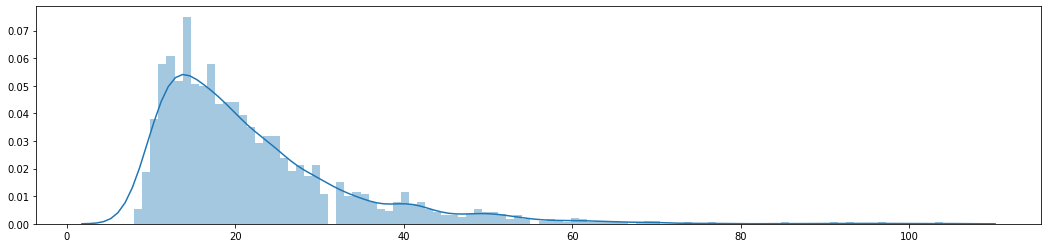

In [122]:
plt.figure(figsize=(18,4))
distplot(returns, bins=100)

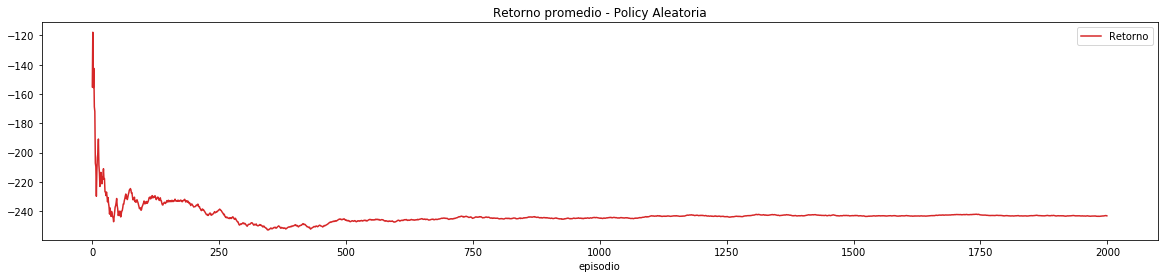

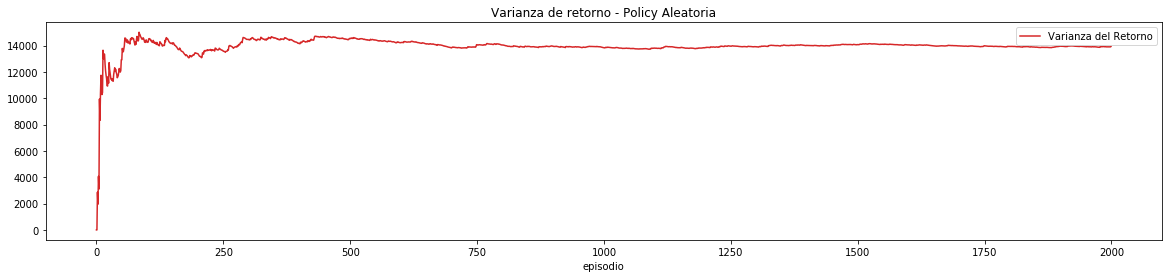

In [30]:
plt.figure(figsize=(20,4))
plt.plot(run_mean, c='C3', label='Retorno')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()
plt.figure(figsize=(20,4))
plt.plot(run_var, c='C3', label='Varianza del Retorno')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()

# Conclusiones

El retorno cambia con cada episodio como es de esperar. Es una variable aleatoria -> Tiene una media y una varianza (alta)

Su distribución depende del entorno. 

¿Si la politica hubiera sido deterministica, dado cualquier entorno, el retorno sería aleatorio? ¿Que pasa si sabemos que en el lunarlander tenemos viento?



# Preguntas:

Al fijar una semilla, el estado inicial $s_0$ estado es siempre el mismo. Cual es el estado inicial de cada entorno con una semilla de 42?

In [39]:
env_ll.seed(42)
s_0 = env_ll.reset()
print(s_0)

[-0.00499964  1.4194578  -0.506422    0.37943238  0.00580009  0.11471219
  0.          0.        ]


Teniendo en cuanto lo anterior ¿El retorno estimado es la $V(s_0)$ o la $Q(s_0, a_0)$?

In [ ]:
def Q_with_random_policy(env, a_0, seed=42):
    done = False
    env.seed(seed)
    env.reset()
    rewards = []
    _, reward, done, _ = env.step(a_0)
    rewards.append(reward)
    while not done:
        action = np.random.randint(env.action_space.n)
        _, reward, done, _ = env.step(action)
        rewards.append(reward)
    return sum(rewards)

In [78]:
Q_with_random_policy(env_cp, 0)

23.0

In [ ]:
def monte_carlo_Q_with_random_policy(env, a_0, seed=42, N=500):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    return_ = Q_with_random_policy(env, a_0)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.get_mean())
    returns.append(return_)
  print()
  returns = np.array(returns)
  run_var = np.array(run_var)
  run_mean = np.array(run_mean)
  return run_mean, run_var, returns

In [119]:
# Descomentar/comentar para cartpole
# run_mean_00, run_var_00, returns_00 = monte_carlo_Q_with_random_policy(env_cp, 0, N=2000)
# run_mean_01, run_var_01, returns_01 = monte_carlo_Q_with_random_policy(env_cp, 0, N=2000)
# run_mean_10, run_var_10, returns_10 = monte_carlo_Q_with_random_policy(env_cp, 1, N=2000)
# run_mean_11, run_var_11, returns_11 = monte_carlo_Q_with_random_policy(env_cp, 1, N=2000)

# Descomentar/comentar para lunarlander
run_mean_00, run_var_00, returns_00 = monte_carlo_Q_with_random_policy(env_ll, 0, N=500)
run_mean_01, run_var_01, returns_01 = monte_carlo_Q_with_random_policy(env_ll, 0, N=500)
run_mean_10, run_var_10, returns_10 = monte_carlo_Q_with_random_policy(env_ll, 1, N=500)
run_mean_11, run_var_11, returns_11 = monte_carlo_Q_with_random_policy(env_ll, 1, N=500)

Episodio: 499
Episodio: 499
Episodio: 499
Episodio: 499


In [ ]:
from seaborn import distplot

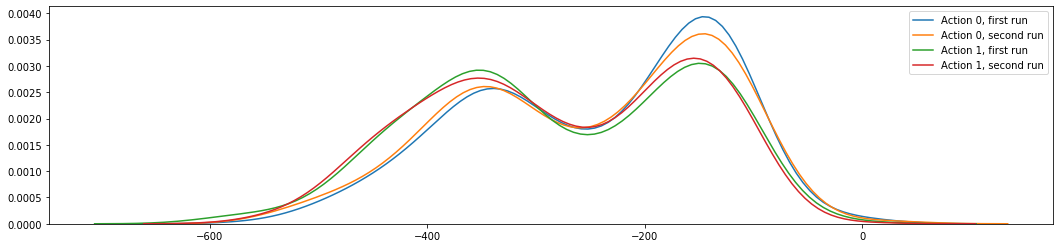

In [124]:
plt.figure(figsize=(18,4))
distplot(returns_00, hist=False, label='Action 0, first run')
distplot(returns_01, hist=False, label='Action 0, second run')
distplot(returns_10, hist=False, label='Action 1, first run')
distplot(returns_11, hist=False, label='Action 1, second run')

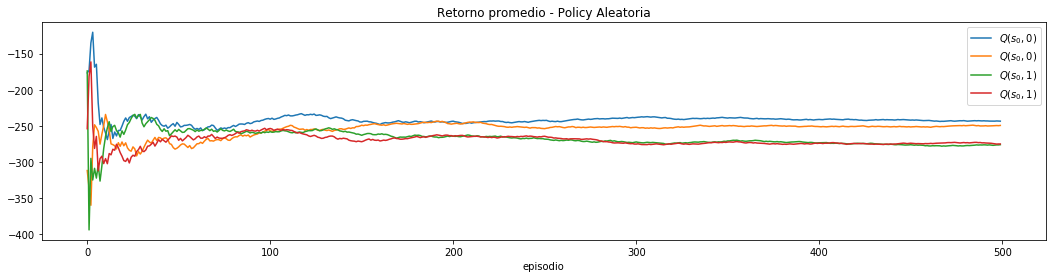

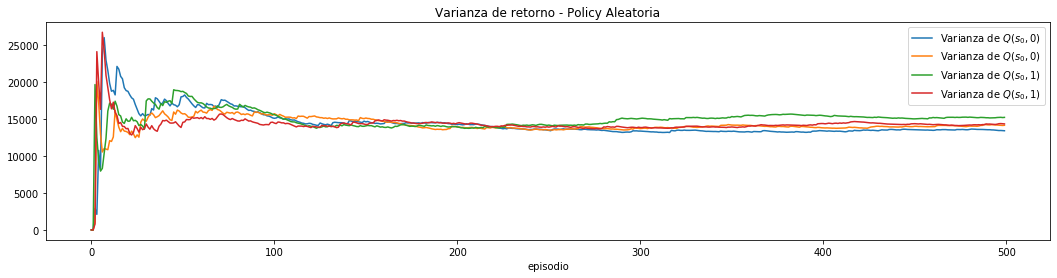

In [125]:
plt.figure(figsize=(18,4))
plt.plot(run_mean_00, label='$Q(s_0, 0)$')
plt.plot(run_mean_01, label='$Q(s_0, 0)$')
plt.plot(run_mean_10, label='$Q(s_0, 1)$')
plt.plot(run_mean_11, label='$Q(s_0, 1)$')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()
plt.figure(figsize=(18,4))
plt.plot(run_var_00, label='Varianza de $Q(s_0, 0)$')
plt.plot(run_var_01, label='Varianza de $Q(s_0, 0)$')
plt.plot(run_var_10, label='Varianza de $Q(s_0, 1)$')
plt.plot(run_var_11, label='Varianza de $Q(s_0, 1)$')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()

# Red neuronal como policy
Armar una red neuronal con entrada igual a la dimensión del espacio de observación y salida igual a la dimensión del espacio de acción.

Con una sola capa oculta y función de activación relu en la misma

¿Cual es la función de activación a la salida?

In [ ]:
def get_policy(env, hidden_layer_neurons = 128):
    output_shape = env.action_space.n
    input_shape = env.observation_space.shape
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [128]:
model = get_policy(env_cp)
model.summary()
print(f'La dimensión de entrada de la red es {model.input.shape}')




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
La dimensión de entrada de la red es (?, 4)


In [ ]:
def run_episode(env, model, seed=42, explore=True):
    done = False
    if seed>0:
        env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    while not done:
        actions_dist = model.predict_proba(obs.reshape(-1, env.observation_space.shape[0]))
        if explore:
            sampled_action = np.random.choice(range(env.action_space.n), p=actions_dist[0])
        else:
            sampled_action = np.argmax(actions_dist[0])
        obs_, reward, done, _ = env.step(sampled_action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(sampled_action)
        obs = obs_
    return observations, actions, rewards

In [ ]:
def monte_carlo(env, model, seed=42, N=500, explore=True, k=20):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    observations, actions, rewards = run_episode(env, model, seed=seed, explore=explore)
    return_ = np.sum(rewards)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.get_mean())
    returns.append(return_)
  print()
  returns = np.array(returns)
  return run_mean, run_var, returns

In [138]:
%time run_mean, run_var, returns = monte_carlo(env_cp, model, seed=42, N=2000)

Episodio: 1999
CPU times: user 1min 2s, sys: 5.33 s, total: 1min 7s
Wall time: 51.5 s


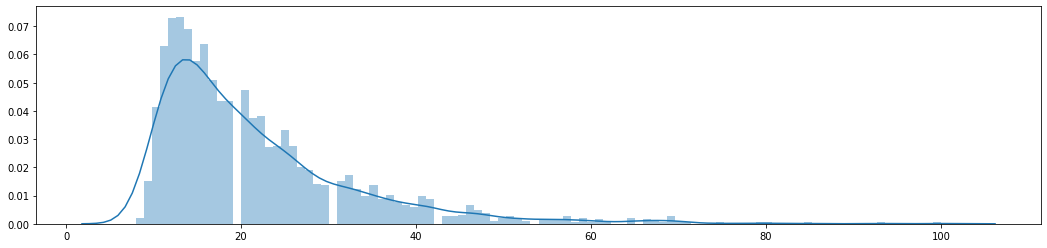

In [140]:
# Notar que es muy similar a la random policy
plt.figure(figsize=(18,4))
distplot(returns, bins=100)

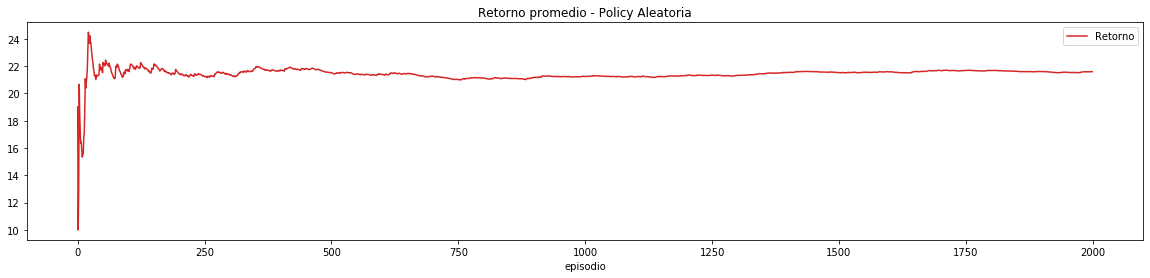

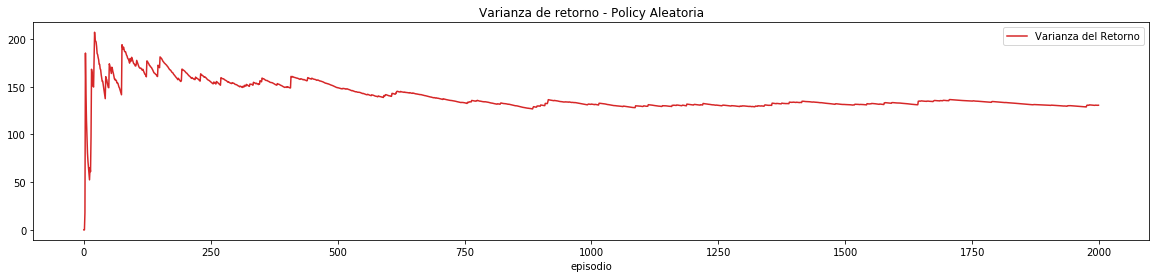

In [142]:
plt.figure(figsize=(20,4))
plt.plot(run_mean, c='C3', label='Retorno')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()
plt.figure(figsize=(20,4))
plt.plot(run_var, c='C3', label='Varianza del Retorno')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()

# Modelo entrenado

In [ ]:
from keras.models import load_model

In [ ]:
trained_model = load_model('/content/cartpole-trained.hdf5', compile=False)
# trained_model = load_model('/content/lunar-lander-trained.hdf5', compile=False)

In [151]:
# Puede tardar mas de 2 mins
%time run_mean_trained_explore, run_var_trained_explore, returns_trained_explore = monte_carlo(env_cp, trained_model, seed=42, N=100, explore=True)
%time run_mean_trained, run_var_trained, returns_trained = monte_carlo(env_cp, trained_model, seed=42, N=100, explore=False)

Episodio: 99
CPU times: user 45 s, sys: 3.85 s, total: 48.8 s
Wall time: 36.9 s
Episodio: 99
CPU times: user 36.7 s, sys: 3.26 s, total: 39.9 s
Wall time: 29.9 s


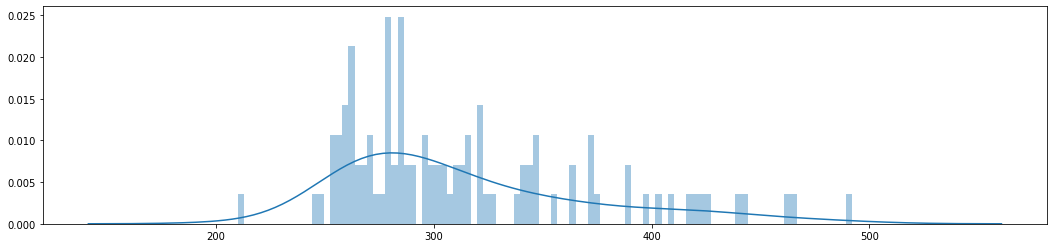

In [157]:
# Notar como cambia la distribución de regards
plt.figure(figsize=(18,4))
distplot(returns_trained_explore, bins=100, label='explore')

In [158]:
returns_trained

array([277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277.])

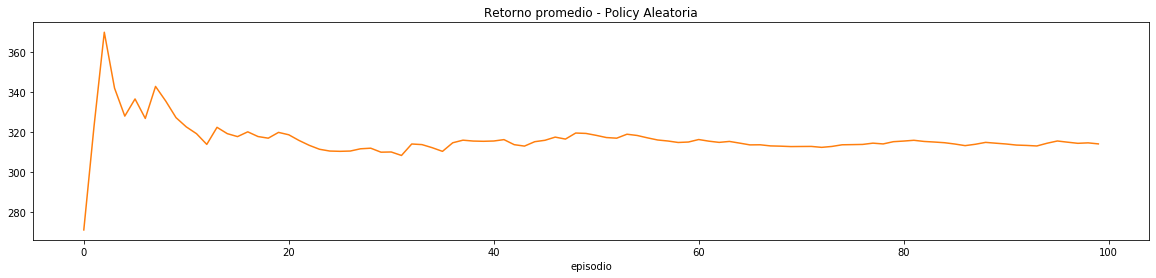

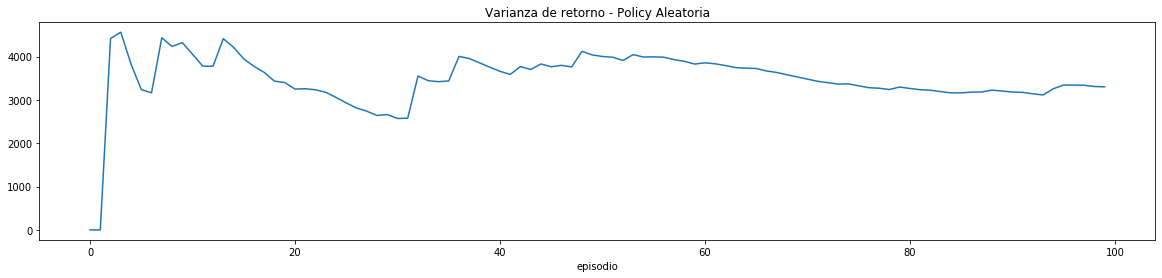

In [159]:
plt.figure(figsize=(20,4))
# plt.scatter(range(len(returns_trained[:N])), returns_trained[:N], c='C0')
plt.plot(run_mean_trained_explore, c='C1')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(run_var_trained_explore)
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()